In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import dbcv
from sklearn.cluster import DBSCAN
import hdbscan
from DBSCANPP import DBSCANPP
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import pairwise_distances

In [4]:
#Importo tutti i datasets forniti
dt_neuroblastoma = pd.read_csv(r"C:\Users\Alessandro\Desktop\EHR_datasets\10_7717_peerj_5665_dataYM2018_neuroblastoma.csv")
dt_sepsis = pd.read_csv(r"C:\Users\Alessandro\Desktop\EHR_datasets\journal.pone.0148699_S1_Text_Sepsis_SIRS_EDITED.csv")
dt_depression_heart_pressure = pd.read_csv(r"C:\Users\Alessandro\Desktop\EHR_datasets\journal.pone.0158570_S2File_depression_heart_failure_v2.csv")
dt_cardiac_arrest = pd.read_csv(r"C:\Users\Alessandro\Desktop\EHR_datasets\journal.pone.0175818_S1Dataset_Spain_cardiac_arrest_EDITED..csv")
dt_diabetes = pd.read_csv(r"C:\Users\Alessandro\Desktop\EHR_datasets\journal.pone.0216416_Takashi2019_diabetes_type1_dataset_preprocessed.csv")

In [94]:
def calculate_dbcv_hdbscan(X, min_cluster_size, min_samples, metric):
    clusterer = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, min_samples = min_samples, metric = metric)
    labels = clusterer.fit_predict(X)
    score = dbcv.dbcv(X, labels, check_duplicates = False)
    return score, labels

def calculate_dbcv_dbscan(X, eps, min_samples, metric):
    dbscan = DBSCAN(eps = eps, min_samples = min_samples, metric = metric)
    labels = dbscan.fit_predict(X)
    score = dbcv.dbcv(X, labels, check_duplicates = False)
    return score, labels

def calculate_dbcv_dbscanpp(X, p, eps_density, eps_clustering, minPts):
    dbscanpp = DBSCANPP(p=p, eps_density=eps_density, eps_clustering=eps_clustering, minPts=minPts)
    labels = dbscanpp.fit_predict(X, init="uniform", cluster_outliers=False)

    # Filtra solo i punti che non sono rumore
    clustered_indices = labels != -1

    # Se tutti i punti sono rumore, ritorna 0.0 e le etichette
    if np.sum(clustered_indices) == 0:
        return 0.0, labels

    # Se tutto va bene, calcola il DBCV solo sui punti clusterizzati
    try:
        score = dbcv.dbcv(X[clustered_indices], labels[clustered_indices], check_duplicates=False)
    except Exception as e:
        #print(f"Errore DBCV per p={p}, eps_d={eps_density}, eps_c={eps_clustering}, minPts={minPts}: {e}")
        score = 0.0

    return score, labels
    
def calculate_labels(labels):
    n_rumore = np.sum(labels == -1)
    n_total = len(labels)
    percentuale_rumore = (n_rumore / n_total) * 100
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    return percentuale_rumore, n_clusters

In [8]:
dt_diabetes_clean = dt_diabetes.dropna()
dt_diabetes_clean

,age,duration.of.diabetes,body_mass_index,TDD,basal,bolus,HbA1c,eGFR,perc.body.fat,adiponectin,free.testosterone,SMI,grip.strength,knee.extension.strength,gait.speed,ucOC,OC,weight_kg,insulin_regimen_binary,sex_0man_1woman
0,31,17,22,43.7,6.3,37.4,6.3,82.9,0.2,14.3,0.8,6.9,30.3,18.2,0.8,19.1,49.6,54.625000,0,1
1,31,25,26,64.0,16.0,48.0,7.8,92.4,0.3,10.0,9.8,7.5,39.7,25.2,1.5,4.0,17.4,80.000000,1,0
2,32,26,21,27.4,10.5,16.9,5.8,84.9,0.2,16.1,1.1,6.1,18.4,18.2,1.2,2.0,10.8,54.800000,0,1
3,25,17,21,60.0,14.1,45.9,7.2,92.7,0.2,6.6,1.3,6.5,31.2,17.8,1.4,3.5,14.5,50.000000,1,1
4,39,35,33,61.0,21.3,39.6,7.6,108.6,0.4,13.8,10.0,8.3,42.1,23.9,1.3,2.5,12.2,101.666667,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,36,28,19,47.0,30.1,16.9,9.2,50.7,0.2,14.5,0.7,5.9,24.7,25.2,1.7,16.1,44.4,47.000000,1,1
63,47,34,25,28.0,7.0,21.0,6.9,76.8,0.3,11.8,5.3,7.3,25.6,13.4,1.5,2.1,12.9,56.000000,1,0
64,21,15,26,72.0,25.9,46.1,7.9,114.2,0.2,13.4,17.3,8.0,39.9,26.1,1.5,8.4,27.1,72.000000,1,0
65,36,29,24,34.0,16.0,18.0,6.8,93.7,0.2,10.8,8.0,8.0,54.5,29.2,1.7,4.8,17.0,68.000000,1,0


In [10]:
#PREPROCESSING DI dt_diabetes_clean
colonne_numeriche = [
    'age', 'duration.of.diabetes', 'body_mass_index', 'TDD', 'basal', 'bolus',
    'HbA1c', 'eGFR', 'perc.body.fat', 'adiponectin', 'free.testosterone',
    'SMI', 'grip.strength', 'knee.extension.strength', 'gait.speed',
    'ucOC', 'OC', 'weight_kg'
]
colonne_binarie = ['insulin_regimen_binary', 'sex_0man_1woman']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), colonne_numeriche),
        ('bin', 'passthrough', colonne_binarie)
    ]
)

X_processed = preprocessor.fit_transform(dt_diabetes_clean)

#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(dt_diabetes_clean)

In [20]:
#APPLICAZIONE DBSCAN
eps_values = np.arange(0.1, 4.0, 0.1)
min_samples_values = np.arange(5, 30, 2)
metrics = ['euclidean', 'manhattan', 'cosine']

risultati = []
for metric in metrics:
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbcv_score, labels = calculate_dbcv_dbscan(X_processed, eps, min_samples, metric)
            percentuale_rumore, n_clusters = calculate_labels(labels)
            risultati.append({
                "eps": eps,
                "min_samples": min_samples,
                "metric": metric,
                "dbcv": dbcv_score,
                "noise_%": percentuale_rumore,
                "n_clusters": n_clusters
            })

df_results = pd.DataFrame(risultati)
df_results

,eps,min_samples,metric,dbcv,noise_%,n_clusters
0,0.1,5,euclidean,0.0,100.0,0
1,0.1,7,euclidean,0.0,100.0,0
2,0.1,9,euclidean,0.0,100.0,0
3,0.1,11,euclidean,0.0,100.0,0
4,0.1,13,euclidean,0.0,100.0,0
...,...,...,...,...,...,...
1516,3.9,21,cosine,1.0,0.0,1
1517,3.9,23,cosine,1.0,0.0,1
1518,3.9,25,cosine,1.0,0.0,1
1519,3.9,27,cosine,1.0,0.0,1


In [22]:
filtered_df = df_results[
    df_results['n_clusters'] > 1
]
filtered_df

,eps,min_samples,metric,dbcv,noise_%,n_clusters
299,2.4,5,euclidean,0.077658,85.074627,2
312,2.5,5,euclidean,0.030330,80.597015,2
325,2.6,5,euclidean,0.049618,74.626866,2
455,3.6,5,euclidean,0.134095,29.850746,2
468,3.7,5,euclidean,0.143468,23.880597,2
481,3.8,5,euclidean,0.145671,22.388060,2
494,3.9,5,euclidean,0.145671,22.388060,2
1040,0.3,5,cosine,0.086033,83.582090,2
1053,0.4,5,cosine,0.127115,22.388060,3
1054,0.4,7,cosine,0.225477,35.820896,2


In [16]:
##Migliore combinazione --> Eps = 0.5, MinPts = 11, cosine, dbcv = 0.309285 e noise_% = 32.835821
#Refinement
eps_values = np.arange(0.4, 0.6, 0.02)
min_samples_values = range(9, 15)
risultati_refined = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbcv_score, labels = calculate_dbcv_dbscan(X_scaled, eps, min_samples, "cosine")
        percentuale_rumore, n_clusters = calculate_labels(labels)
        risultati_refined.append({
            "eps": eps,
            "min_samples": min_samples,
            "metric": "cosine",
            "dbcv": dbcv_score,
            "noise_%": percentuale_rumore,
            "n_clusters": n_clusters
        })

df_refined = pd.DataFrame(risultati_refined).sort_values(by="dbcv", ascending=False)

In [18]:
df_refined

,eps,min_samples,metric,dbcv,noise_%,n_clusters
31,0.50,10,cosine,0.341839,26.865672,2
52,0.56,13,cosine,0.337992,26.865672,2
53,0.56,14,cosine,0.335180,28.358209,2
32,0.50,11,cosine,0.309285,32.835821,2
39,0.52,12,cosine,0.303443,32.835821,2
46,0.54,13,cosine,0.296686,37.313433,2
25,0.48,10,cosine,0.291966,35.820896,2
47,0.54,14,cosine,0.291026,40.298507,2
40,0.52,13,cosine,0.286877,38.805970,2
34,0.50,13,cosine,0.271409,43.283582,2


In [ ]:
#Miglior risutlato DBCV = 0.341839, noise_% = 26.865672 e n_clusters = 2

In [26]:
##APPLICAZIONE HDBSCAN
min_cluster_size_values = np.arange(3, 15, 1)      
min_samples_values = np.arange(2, 10, 1)           
metrics = ['euclidean', 'manhattan', 'chebyshev', 'canberra']

risultati = []
for metric in metrics:
    for min_cluster_size  in min_cluster_size_values:
        for min_samples in min_samples_values:
            hdbcv_score, labels = calculate_dbcv_hdbscan(X_processed, min_cluster_size, min_samples, metric)
            percentuale_rumore, n_clusters = calculate_labels(labels)
            risultati.append({
                "metric": metric,
                "min_cluster_size": min_cluster_size,
                "min_samples": min_samples,
                "dbcv": hdbcv_score,
                "noise_%": percentuale_rumore,
                "n_clusters": n_clusters
            })

df_results = pd.DataFrame(risultati)
df_results

,metric,min_cluster_size,min_samples,dbcv,noise_%,n_clusters
0,euclidean,3,2,0.149824,20.895522,2
1,euclidean,3,3,0.172281,28.358209,2
2,euclidean,3,4,0.169230,29.850746,2
3,euclidean,3,5,0.000000,100.000000,0
4,euclidean,3,6,0.000000,100.000000,0
...,...,...,...,...,...,...
379,canberra,14,5,0.000000,100.000000,0
380,canberra,14,6,0.000000,100.000000,0
381,canberra,14,7,0.000000,100.000000,0
382,canberra,14,8,0.000000,100.000000,0


In [28]:
filtered_df = df_results[
    (df_results['n_clusters'] > 1) &
    (df_results['dbcv'] > 0.36 )
]
filtered_df

,metric,min_cluster_size,min_samples,dbcv,noise_%,n_clusters
294,canberra,3,8,0.370149,41.791045,2
302,canberra,4,8,0.370149,41.791045,2
310,canberra,5,8,0.370149,41.791045,2
318,canberra,6,8,0.370149,41.791045,2


In [22]:
#Refinement
min_cluster_size_values = np.arange(2, 6, 1)  # più vicino a 3
min_samples_values = np.arange(5, 9, 1)       # vicino a 6
metrics = ['euclidean', 'manhattan', 'canberra', 'chebyshev']

risultati_refined = []
for metric in metrics:
    for min_cluster_size  in min_cluster_size_values:
        for min_samples in min_samples_values:
            hdbcv_score, labels = calculate_dbcv_hdbscan(X_scaled, min_cluster_size, min_samples, metric)
            percentuale_rumore, n_clusters = calculate_labels(labels)
            risultati_refined.append({
                "metric": metric,
                "min_cluster_size": min_cluster_size,
                "min_samples": min_samples,
                "dbcv": hdbcv_score,
                "noise_%": percentuale_rumore,
                "n_clusters": n_clusters
            })

df_refined = pd.DataFrame(risultati_refined).sort_values(by="dbcv", ascending=False)
df_refined

,metric,min_cluster_size,min_samples,dbcv,noise_%,n_clusters
47,canberra,5,8,0.379546,41.791045,2
43,canberra,4,8,0.379546,41.791045,2
39,canberra,3,8,0.379546,41.791045,2
35,canberra,2,8,0.379546,41.791045,2
5,euclidean,3,6,0.379141,32.835821,2
...,...,...,...,...,...,...
60,chebyshev,5,5,-0.140145,34.328358,3
53,chebyshev,3,6,-0.145435,38.805970,3
49,chebyshev,2,6,-0.145435,38.805970,3
57,chebyshev,4,6,-0.145435,38.805970,3


In [ ]:
#Miglior combinazione min_cluster_size = 5, min_samples = 8, dbcv = 0.379546, noise_% = 41.791045, clusters = 2

In [84]:
#dbscanpp = DBSCANPP(p=0.3, eps_density=2, eps_clustering=1.5, minPts=5)
#labels = dbscanpp.fit_predict(X_scaled, init="uniform", cluster_outliers=False)
#score = dbcv.dbcv(X_scaled, labels, check_duplicates = False)
#percentuale_rumore, n_clusters = calculate_labels(labels)
#print(f'dbcv:{score}, n_clusters = {n_clusters}, noise_%: {percentuale_rumore},')
#if (eps_c < eps_d):
                #continue  # salta combinazioni non valide
            #for minPts in minPts_values:
                #dbcv_score, labels = calculate_dbcv_dbscanpp(X_scaled, p, eps_d, eps_c, minPts)
                #percentuale_rumore, n_clusters = calculate_labels(labels)
                #if n_clusters == 0:
                  #  continue
               # risultati.append({
               #     'p': p,
                  #  'eps_density': eps_d,
                #    'eps_clustering': eps_c,
                #    'minPts': minPts,
                 #   'dbcv': dbcv_score,
                 #   'noise_%': percentuale_rumore,
                  #  'n_clusters': n_clusters
               # })

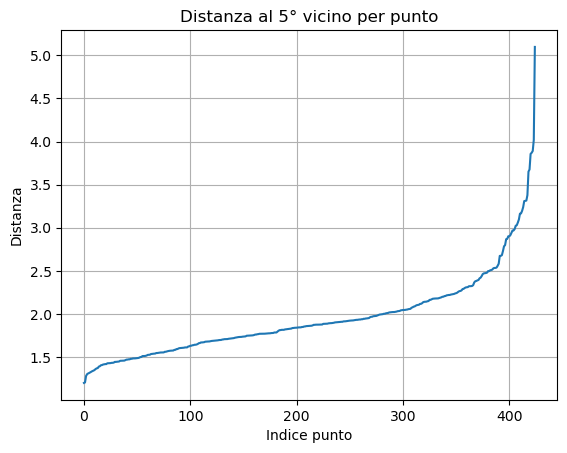

In [99]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_processed)
distances, indices = neighbors_fit.kneighbors(X_processed)

distances = np.sort(distances[:, -1])  # distanza al 5° vicino
plt.plot(distances)
plt.title("Distanza al 5° vicino per punto")
plt.xlabel("Indice punto")
plt.ylabel("Distanza")
plt.grid()
plt.show()

In [101]:
##APPLICAZIONE DBSCAN++
p_values = np.linspace(0.1, 0.5, 5)
eps_density_values = [2.2, 2.5, 2.8]
eps_clustering_values = [3.0, 3.5, 4.0, 4.5]
minPts_values = range(3, 10)

risultati = []

for p in p_values:
    for eps_d in eps_density_values:
        for eps_c in eps_clustering_values:
            for minPts in minPts_values:
                try:
                    dbcv_score, labels = calculate_dbcv_dbscanpp(X_processed, p, eps_d, eps_c, minPts)
                    percentuale_rumore, n_clusters = calculate_labels(labels)
                    risultati.append({
                        'p': p,
                        'eps_density': eps_d,
                        'eps_clustering': eps_c,
                        'minPts': minPts,
                        'dbcv': dbcv_score,
                        'noise_%': percentuale_rumore,
                        'n_clusters': n_clusters
                    })
                except Exception as e:
                    print(f"Saltati parametri: p={p}, eps_density={eps_d}, eps_clustering={eps_c}, minPts={minPts} - Errore: {e}")
                    continue
                    
df_results = pd.DataFrame(risultati)
df_results

,p,eps_density,eps_clustering,minPts,dbcv,noise_%,n_clusters
0,0.1,2.2,3.0,3,0.016919,78.823529,2
1,0.1,2.2,3.0,4,-0.295142,75.294118,3
2,0.1,2.2,3.0,5,-0.021198,85.411765,4
3,0.1,2.2,3.0,6,1.000000,64.235294,1
4,0.1,2.2,3.0,7,-0.375912,69.411765,2
...,...,...,...,...,...,...,...
415,0.5,2.8,4.5,5,1.000000,9.176471,1
416,0.5,2.8,4.5,6,1.000000,12.235294,1
417,0.5,2.8,4.5,7,1.000000,9.647059,1
418,0.5,2.8,4.5,8,1.000000,10.117647,1


In [111]:
filtered_df = df_results[
    (df_results['n_clusters'] > 1) &
    (df_results['dbcv'] > 0.5)
]
filtered_df

,p,eps_density,eps_clustering,minPts,dbcv,noise_%,n_clusters
315,0.4,2.8,3.5,3,0.607840,11.058824,2
396,0.5,2.8,3.0,7,0.997382,10.117647,2


In [ ]:
#dt_depression_heart_pressure

In [113]:
#ANALISI DI ALTRO DATASET dt_depression_heart_pressure
dt_depression_heart_pressure_clean = dt_depression_heart_pressure.dropna()
dt_depression_heart_pressure_clean = dt_depression_heart_pressure_clean.drop(columns=['Death (1=Yes, 0=No)', 'Hospitalized (1=Yes, 0=No)', 'Time from HF to hospitalization (days)', 'Time from HF to Death (days)'])
dt_depression_heart_pressure_clean


,Age (years),"Male (1=Yes, 0=No)",PHQ-9,Systolic BP (mm Hg),Estimated glomerular filtration rate,Ejection fraction (%),Serum sodium (mmol/l),Blood urea nitrogen (mg/dl),"Etiology HF(1=Yes, 0=No)",Prior diabetes mellitus,"Elevated level of BNP/NT-BNP (1=Yes, 0=No)"
0,93,0,1,145.0,46.352457,60.50,137,26,1,1,1
1,99,1,8,115.0,32.827851,65.00,140,75,1,0,1
2,83,1,4,121.0,57.821591,65.00,141,28,0,0,1
3,86,1,4,113.0,63.469884,32.50,141,47,0,1,1
4,84,1,3,142.0,57.681188,58.00,137,32,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
420,50,1,3,143.0,79.094655,49.50,137,27,1,1,1
421,73,1,11,155.0,29.486806,58.00,139,42,0,0,1
422,63,1,17,135.0,113.901326,27.40,130,17,0,1,1
423,48,1,4,172.0,58.919011,16.83,140,34,0,0,1


In [119]:
#PREPROCESSING 
colonne_numeriche = ['Age (years)', 'PHQ-9', 'Systolic BP (mm Hg)', 'Estimated glomerular filtration rate', 'Ejection fraction (%)', 'Serum sodium (mmol/l)', 'Blood urea nitrogen (mg/dl)']
colonne_binarie = ['Male (1=Yes, 0=No)', 'Etiology HF(1=Yes, 0=No)', 'Prior diabetes mellitus', 'Elevated level of BNP/NT-BNP (1=Yes, 0=No)']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), colonne_numeriche),
        ('bin', 'passthrough', colonne_binarie)
    ])
X_processed_2 = preprocessor.fit_transform(dt_depression_heart_pressure_clean)

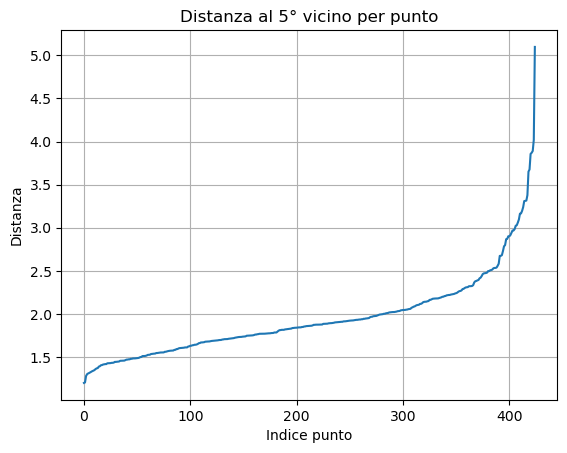

In [121]:
#Metodo del Gomito (Distanza del 5 vicino)
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_processed_2)
distances, indices = neighbors_fit.kneighbors(X_processed_2)

distances = np.sort(distances[:, -1])  # distanza al 5° vicino
plt.plot(distances)
plt.title("Distanza al 5° vicino per punto")
plt.xlabel("Indice punto")
plt.ylabel("Distanza")
plt.grid()
plt.show()

In [137]:
##DBSCAN
#eps_values = [2.5, 2.6, 2.7, 2.8, 2.9]
eps_values = np.arange(1.8, 2.5, 0.1)
min_samples_values = [4, 5, 6]
metrics = ['euclidean', 'manhattan', 'cosine']

risultati = []
for metric in metrics:
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbcv_score, labels = calculate_dbcv_dbscan(X_processed_2, eps, min_samples, metric)
            percentuale_rumore, n_clusters = calculate_labels(labels)
            risultati.append({
                "eps": eps,
                "min_samples": min_samples,
                "metric": metric,
                "dbcv": dbcv_score,
                "noise_%": percentuale_rumore,
                "n_clusters": n_clusters
            })

df_results = pd.DataFrame(risultati)
df_results

,eps,min_samples,metric,dbcv,noise_%,n_clusters
0,1.8,4,euclidean,-0.029504,33.176471,2
1,1.8,5,euclidean,0.628235,37.176471,1
2,1.8,6,euclidean,0.590588,40.941176,1
3,1.9,4,euclidean,0.781176,21.882353,1
4,1.9,5,euclidean,0.750588,24.941176,1
...,...,...,...,...,...,...
58,2.3,5,cosine,1.000000,0.000000,1
59,2.3,6,cosine,1.000000,0.000000,1
60,2.4,4,cosine,1.000000,0.000000,1
61,2.4,5,cosine,1.000000,0.000000,1


In [141]:
filtered_df = df_results[
    df_results['n_clusters'] > 1
]
filtered_df

,eps,min_samples,metric,dbcv,noise_%,n_clusters
0,1.8,4,euclidean,-0.029504,33.176471,2
36,2.3,4,manhattan,0.015592,98.117647,2
39,2.4,4,manhattan,0.025890,96.235294,4


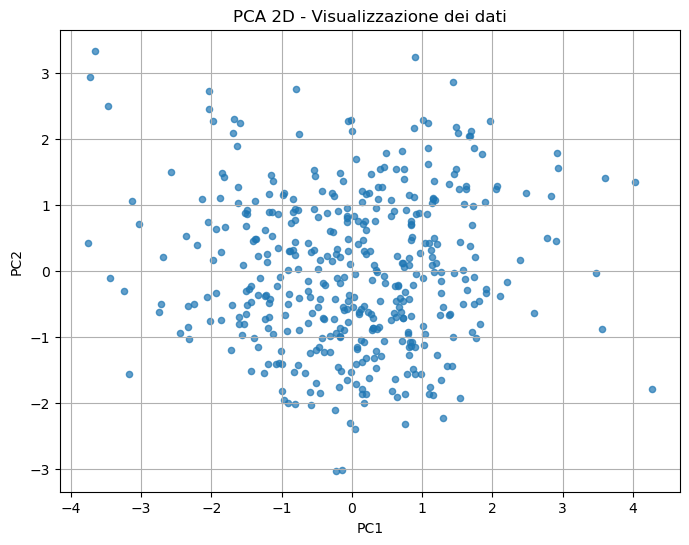

In [143]:
#PCA 2D
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_processed_2)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], s=20, alpha=0.7)
plt.title("PCA 2D - Visualizzazione dei dati")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [145]:
#HDBSCAN
min_cluster_size_values = range(5, 51, 5)      
min_samples_values = [None, 5, 10, 15, 20]           
metrics = ['euclidean', 'manhattan', 'chebyshev', 'canberra']

risultati = []
for metric in metrics:
    for min_cluster_size  in min_cluster_size_values:
        for min_samples in min_samples_values:
            hdbcv_score, labels = calculate_dbcv_hdbscan(X_processed_2, min_cluster_size, min_samples, metric)
            percentuale_rumore, n_clusters = calculate_labels(labels)
            risultati.append({
                "metric": metric,
                "min_cluster_size": min_cluster_size,
                "min_samples": min_samples,
                "dbcv": hdbcv_score,
                "noise_%": percentuale_rumore,
                "n_clusters": n_clusters
            })

df_results = pd.DataFrame(risultati)
df_results

,metric,min_cluster_size,min_samples,dbcv,noise_%,n_clusters
0,euclidean,5,NaN,0.026454,93.176471,3
1,euclidean,5,5.0,0.026454,93.176471,3
2,euclidean,5,10.0,0.008709,96.941176,2
3,euclidean,5,15.0,0.009619,96.470588,2
4,euclidean,5,20.0,0.000000,100.000000,0
...,...,...,...,...,...,...
195,canberra,50,NaN,0.000000,100.000000,0
196,canberra,50,5.0,0.000000,100.000000,0
197,canberra,50,10.0,0.000000,100.000000,0
198,canberra,50,15.0,0.000000,100.000000,0


In [149]:
filtered_df = df_results[
    (df_results['n_clusters'] > 1) 
]
filtered_df

,metric,min_cluster_size,min_samples,dbcv,noise_%,n_clusters
0,euclidean,5,NaN,0.026454,93.176471,3
1,euclidean,5,5.0,0.026454,93.176471,3
2,euclidean,5,10.0,0.008709,96.941176,2
3,euclidean,5,15.0,0.009619,96.470588,2
50,manhattan,5,NaN,0.010131,90.352941,3
51,manhattan,5,5.0,0.010131,90.352941,3
100,chebyshev,5,NaN,-0.285945,42.352941,2
101,chebyshev,5,5.0,-0.285945,42.352941,2
102,chebyshev,5,10.0,-0.223931,59.529412,2
103,chebyshev,5,15.0,-0.067209,76.470588,2


In [171]:
#ANALISI DI ALTRO DATASET dt_cardiac_arrest
dt_cardiac_arrest_clean = dt_cardiac_arrest.dropna()
X_df = dt_cardiac_arrest_clean.drop(columns=['Exitus'])
X_df

,sex_woman,Age_years,Endotracheal_intubation,Functional_status,Asystole,Cardiac_arrest_at_home,Bystander,Time_min,Cardiogenic
0,0,33.0,1,3.0,1,1,1,6,1
1,1,39.0,1,3.0,1,1,1,11,1
2,0,49.0,1,3.0,0,0,1,24,0
3,0,49.0,1,3.0,0,1,1,8,1
4,0,50.0,1,3.0,0,0,1,16,1
...,...,...,...,...,...,...,...,...,...
417,0,72.0,1,3.0,0,1,1,10,1
418,0,63.0,1,3.0,1,1,1,20,1
419,0,69.0,1,2.0,1,0,0,10,1
420,0,65.0,1,3.0,0,1,0,16,0


In [175]:
colonna_numerica = ['Age_years', 'Time_min']
colonna_ordinale = ['Functional_status'] 
colonna_binaria = ['sex_woman', 'Endotracheal_intubation', 'Asystole', 'Cardiac_arrest_at_home', 'Bystander', 'Cardiogenic']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), colonna_numerica),
        ('ord', StandardScaler(), colonna_ordinale),
        ('bin', 'passthrough', colonna_binaria)
    ])

X_processed = preprocessor.fit_transform(X_df)

In [179]:
##DBSCAN
eps_values = np.arange(0.1, 1.5, 0.1)
min_samples_values = np.arange(5, 20, 2)
metrics = ['euclidean', 'manhattan', 'cosine']

risultati = []
for metric in metrics:
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbcv_score, labels = calculate_dbcv_dbscan(X_processed, eps, min_samples, metric)
            percentuale_rumore, n_clusters = calculate_labels(labels)
            risultati.append({
                "eps": eps,
                "min_samples": min_samples,
                "metric": metric,
                "dbcv": dbcv_score,
                "noise_%": percentuale_rumore,
                "n_clusters": n_clusters
            })

df_results = pd.DataFrame(risultati)
df_results

,eps,min_samples,metric,dbcv,noise_%,n_clusters
0,0.1,5,euclidean,0.0,100.0,0
1,0.1,7,euclidean,0.0,100.0,0
2,0.1,9,euclidean,0.0,100.0,0
3,0.1,11,euclidean,0.0,100.0,0
4,0.1,13,euclidean,0.0,100.0,0
...,...,...,...,...,...,...
331,1.4,11,cosine,1.0,0.0,1
332,1.4,13,cosine,1.0,0.0,1
333,1.4,15,cosine,1.0,0.0,1
334,1.4,17,cosine,1.0,0.0,1


In [191]:
filtered_df = df_results[
    (df_results['n_clusters'] > 1) &
    (df_results['dbcv'] > 0.3) &
    (df_results['noise_%'] < 50)
]
filtered_df

,eps,min_samples,metric,dbcv,noise_%,n_clusters
27,1.40,5,manhattan,0.302323,26.682692,2
34,1.45,6,manhattan,0.301069,26.923077,2
47,1.55,7,manhattan,0.312649,23.557692,2


In [189]:
#refinement
##DBSCAN
eps_values = np.arange(1.2, 1.8, 0.05)
min_samples_values = np.arange(2, 8, 1)
metrics = ['manhattan']

risultati = []
for metric in metrics:
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbcv_score, labels = calculate_dbcv_dbscan(X_processed, eps, min_samples, metric)
            percentuale_rumore, n_clusters = calculate_labels(labels)
            risultati.append({
                "eps": eps,
                "min_samples": min_samples,
                "metric": metric,
                "dbcv": dbcv_score,
                "noise_%": percentuale_rumore,
                "n_clusters": n_clusters
            })

df_results = pd.DataFrame(risultati)
df_results

,eps,min_samples,metric,dbcv,noise_%,n_clusters
0,1.2,2,manhattan,-0.180894,24.519231,15
1,1.2,3,manhattan,0.282148,29.807692,4
2,1.2,4,manhattan,-0.137862,34.134615,3
3,1.2,5,manhattan,-0.170046,42.307692,3
4,1.2,6,manhattan,0.509615,49.038462,1
...,...,...,...,...,...,...
73,1.8,3,manhattan,-0.131998,11.778846,3
74,1.8,4,manhattan,0.855769,14.423077,1
75,1.8,5,manhattan,0.846154,15.384615,1
76,1.8,6,manhattan,0.841346,15.865385,1


In [193]:
filtered_df = df_results[
    (df_results['n_clusters'] > 1) &
    (df_results['dbcv'] > 0.3) &
    (df_results['noise_%'] < 50)
]
filtered_df

,eps,min_samples,metric,dbcv,noise_%,n_clusters
27,1.40,5,manhattan,0.302323,26.682692,2
34,1.45,6,manhattan,0.301069,26.923077,2
47,1.55,7,manhattan,0.312649,23.557692,2


In [ ]:
#Best optimization values --> Eps = 1.40, min_samples = 5 --> dbcv = 0.302323, noise = 26.682692, clusters = 2

In [195]:
#HDBSCAN
min_cluster_size_values = np.arange(5, 51, 5)
min_samples_values = np.arange(5, 51, 5)          
metrics = ['euclidean', 'manhattan', 'chebyshev', 'canberra']

risultati = []
for metric in metrics:
    for min_cluster_size  in min_cluster_size_values:
        for min_samples in min_samples_values:
            hdbcv_score, labels = calculate_dbcv_hdbscan(X_processed, min_cluster_size, min_samples, metric)
            percentuale_rumore, n_clusters = calculate_labels(labels)
            risultati.append({
                "metric": metric,
                "min_cluster_size": min_cluster_size,
                "min_samples": min_samples,
                "dbcv": hdbcv_score,
                "noise_%": percentuale_rumore,
                "n_clusters": n_clusters
            })

df_results = pd.DataFrame(risultati)
df_results

,metric,min_cluster_size,min_samples,dbcv,noise_%,n_clusters
0,euclidean,5,5,0.196263,11.538462,2
1,euclidean,5,10,0.191403,17.788462,2
2,euclidean,5,15,0.045045,93.750000,2
3,euclidean,5,20,0.056433,91.826923,2
4,euclidean,5,25,0.035104,94.951923,2
...,...,...,...,...,...,...
395,canberra,50,30,0.000000,100.000000,0
396,canberra,50,35,0.000000,100.000000,0
397,canberra,50,40,0.000000,100.000000,0
398,canberra,50,45,0.000000,100.000000,0


In [201]:
filtered_df = df_results[
    (df_results['n_clusters'] > 1) &
    (df_results['dbcv'] > 0.1) #&
    #(df_results['noise_%'] < 50)
]
filtered_df

,metric,min_cluster_size,min_samples,dbcv,noise_%,n_clusters
0,euclidean,5,5,0.196263,11.538462,2
1,euclidean,5,10,0.191403,17.788462,2
10,euclidean,10,5,0.196263,11.538462,2
11,euclidean,10,10,0.191403,17.788462,2
20,euclidean,15,5,0.196263,11.538462,2
21,euclidean,15,10,0.191403,17.788462,2
30,euclidean,20,5,0.196263,11.538462,2
40,euclidean,25,5,0.196263,11.538462,2
100,manhattan,5,5,0.283536,32.211538,2
208,chebyshev,5,45,0.208712,14.423077,3


In [203]:
#refinement
min_cluster_size_values = np.arange(3, 10, 1)
min_samples_values = np.arange(3, 10, 1)          
metrics = ['euclidean', 'manhattan', 'chebyshev']

risultati = []
for metric in metrics:
    for min_cluster_size  in min_cluster_size_values:
        for min_samples in min_samples_values:
            hdbcv_score, labels = calculate_dbcv_hdbscan(X_processed, min_cluster_size, min_samples, metric)
            percentuale_rumore, n_clusters = calculate_labels(labels)
            risultati.append({
                "metric": metric,
                "min_cluster_size": min_cluster_size,
                "min_samples": min_samples,
                "dbcv": hdbcv_score,
                "noise_%": percentuale_rumore,
                "n_clusters": n_clusters
            })

df_results = pd.DataFrame(risultati)
df_results

,metric,min_cluster_size,min_samples,dbcv,noise_%,n_clusters
0,euclidean,3,3,0.080145,7.692308,2
1,euclidean,3,4,0.082121,7.932692,3
2,euclidean,3,5,0.201574,10.817308,3
3,euclidean,3,6,0.206080,12.019231,3
4,euclidean,3,7,0.205736,12.259615,3
...,...,...,...,...,...,...
142,chebyshev,9,5,-0.215761,0.721154,3
143,chebyshev,9,6,-0.368139,0.721154,3
144,chebyshev,9,7,-0.370310,0.961538,3
145,chebyshev,9,8,-0.185329,6.009615,2


In [207]:
filtered_df = df_results[
    (df_results['n_clusters'] > 1) &
    (df_results['dbcv'] > 0.3) #&
    #(df_results['noise_%'] < 50)
]
filtered_df

,metric,min_cluster_size,min_samples,dbcv,noise_%,n_clusters
49,manhattan,3,3,0.718785,6.971154,2
50,manhattan,3,4,0.300686,26.923077,2
53,manhattan,3,7,0.409875,40.144231,2
57,manhattan,4,4,0.300686,26.923077,2
60,manhattan,4,7,0.409875,40.144231,2
64,manhattan,5,4,0.300686,26.923077,2
67,manhattan,5,7,0.409875,40.144231,2
71,manhattan,6,4,0.300686,26.923077,2
78,manhattan,7,4,0.300686,26.923077,2
85,manhattan,8,4,0.300686,26.923077,2


In [ ]:
#Configurazione ottimale: metric = manhattan, min_cluster_size = 3, min_samples = 3 --> dbcv = 0.718785, noise_% = 6.971154, n_clusters = 2

In [30]:
dt_sepsis

,Age,sex_woman,diagnosis_0EC_1M_2_AC,APACHE II,SOFA,CRP,WBCC,NeuC,LymC,EOC,NLCR,PLTC,MPV,Group,LOS-ICU,Mortality
0,23,0,2,14,0,0.02,10.48,8.66,1.22,40,7.1,176,10.0,0,1,0
1,53,0,2,10,3,9.00,19.16,16.28,0.62,0,26.3,280,10.8,0,1,0
2,83,0,2,8,4,11.91,12.60,9.91,0.72,0,13.8,98,9.2,0,1,0
3,35,0,2,3,0,7.38,7.70,5.97,0.94,20,6.4,254,7.9,0,1,0
4,86,0,2,17,2,4.97,10.64,9.73,0.78,0,12.5,133,11.8,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,84,1,1,18,3,0.30,6.71,5.26,0.81,30,6.5,145,9.7,0,6,0
1253,30,1,1,3,0,0.10,7.89,3.43,3.47,30,1.0,268,10.3,0,1,0
1254,62,1,1,19,6,4.50,4.49,3.53,0.31,20,11.4,188,8.6,0,15,0
1255,31,1,1,16,5,2.00,8.40,6.69,0.76,20,8.8,164,9.0,1,4,0


In [32]:
dt_sepsis_clean = dt_sepsis.dropna()
X_df = dt_sepsis_clean.drop(columns=['Mortality', 'Group'])
X_df

,Age,sex_woman,diagnosis_0EC_1M_2_AC,APACHE II,SOFA,CRP,WBCC,NeuC,LymC,EOC,NLCR,PLTC,MPV,LOS-ICU
0,23,0,2,14,0,0.02,10.48,8.66,1.22,40,7.1,176,10.0,1
1,53,0,2,10,3,9.00,19.16,16.28,0.62,0,26.3,280,10.8,1
2,83,0,2,8,4,11.91,12.60,9.91,0.72,0,13.8,98,9.2,1
3,35,0,2,3,0,7.38,7.70,5.97,0.94,20,6.4,254,7.9,1
4,86,0,2,17,2,4.97,10.64,9.73,0.78,0,12.5,133,11.8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,84,1,1,18,3,0.30,6.71,5.26,0.81,30,6.5,145,9.7,6
1253,30,1,1,3,0,0.10,7.89,3.43,3.47,30,1.0,268,10.3,1
1254,62,1,1,19,6,4.50,4.49,3.53,0.31,20,11.4,188,8.6,15
1255,31,1,1,16,5,2.00,8.40,6.69,0.76,20,8.8,164,9.0,4


In [34]:
#Preprocessing
colonne_binarie = ['sex_woman']
colonne_numeriche = ['Age', 'APACHE II', 'SOFA' ,'CRP', 'WBCC', 'NeuC', 'LymC', 'EOC', 'NLCR', 'PLTC', 'MPV', 'LOS-ICU']
colonna_cat_multiclasse = ['diagnosis_0EC_1M_2_AC']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), colonne_numeriche),
        ('cat', OneHotEncoder(sparse_output=False, drop = 'first'), colonna_cat_multiclasse),
        ('bin', 'passthrough', colonne_binarie)
])

X_processed = preprocessor.fit_transform(X_df)

In [38]:
#DBSCAN
eps_values = np.arange(0.3, 1.6, 0.1)
min_samples_values = np.arange(5, 31, 5)
metrics = ['euclidean', 'manhattan', 'cosine']

risultati = []
for metric in metrics:
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbcv_score, labels = calculate_dbcv_dbscan(X_processed, eps, min_samples, metric)
            percentuale_rumore, n_clusters = calculate_labels(labels)
            risultati.append({
                "eps": eps,
                "min_samples": min_samples,
                "metric": metric,
                "dbcv": dbcv_score,
                "noise_%": percentuale_rumore,
                "n_clusters": n_clusters
            })

df_results = pd.DataFrame(risultati)
df_results

,eps,min_samples,metric,dbcv,noise_%,n_clusters
0,0.3,5,euclidean,0.0,100.0,0
1,0.3,10,euclidean,0.0,100.0,0
2,0.3,15,euclidean,0.0,100.0,0
3,0.3,20,euclidean,0.0,100.0,0
4,0.3,25,euclidean,0.0,100.0,0
...,...,...,...,...,...,...
229,1.5,10,cosine,1.0,0.0,1
230,1.5,15,cosine,1.0,0.0,1
231,1.5,20,cosine,1.0,0.0,1
232,1.5,25,cosine,1.0,0.0,1


In [46]:
filtered_df = df_results[
    (df_results['n_clusters'] > 1) #&
    #(df_results['dbcv'] > 0.1) #&
    #(df_results['noise_%'] < 50)
]
filtered_df

,eps,min_samples,metric,dbcv,noise_%,n_clusters
18,0.6,5,euclidean,0.006286,98.329356,3
24,0.7,5,euclidean,0.033189,94.749403,4
30,0.8,5,euclidean,0.049021,88.066826,9
31,0.8,10,euclidean,0.033063,96.420048,2
36,0.9,5,euclidean,0.045317,80.827367,5
37,0.9,10,euclidean,0.047009,91.010342,3
38,0.9,15,euclidean,0.048163,94.590294,2
42,1.0,5,euclidean,-0.015167,74.781225,4
43,1.0,10,euclidean,0.030916,80.270485,3
44,1.0,15,euclidean,0.036018,89.260143,2


In [229]:
#refinement
eps_values = np.arange(1.1, 1.5, 0.05)
min_samples_values = [5, 6, 7, 8, 9, 10]
metrics = ['euclidean', 'manhattan', 'chebyshev']

risultati = []
for metric in metrics:
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbcv_score, labels = calculate_dbcv_dbscan(X_processed, eps, min_samples, metric)
            percentuale_rumore, n_clusters = calculate_labels(labels)
            risultati.append({
                "eps": eps,
                "min_samples": min_samples,
                "metric": metric,
                "dbcv": dbcv_score,
                "noise_%": percentuale_rumore,
                "n_clusters": n_clusters
            })

df_results = pd.DataFrame(risultati)
df_results

,eps,min_samples,metric,dbcv,noise_%,n_clusters
0,1.10,5,euclidean,0.173517,67.859984,4
1,1.10,6,euclidean,0.295147,70.485282,1
2,1.10,7,euclidean,0.287192,71.280827,1
3,1.10,8,euclidean,-0.108221,72.076372,2
4,1.10,9,euclidean,-0.100163,72.553699,2
...,...,...,...,...,...,...
139,1.45,6,chebyshev,-0.441801,10.501193,3
140,1.45,7,chebyshev,-0.440137,10.739857,3
141,1.45,8,chebyshev,-0.409886,11.376293,3
142,1.45,9,chebyshev,-0.409641,11.614956,3


In [233]:
filtered_df = df_results[
    (df_results['n_clusters'] > 1) &
    (df_results['dbcv'] > 0.2) #&
    #(df_results['noise_%'] < 50)
]
filtered_df

,eps,min_samples,metric,dbcv,noise_%,n_clusters
34,1.35,9,euclidean,0.206278,60.859189,4


In [235]:
#refinement
eps_values = np.arange(1.3, 1.4, 0.01)
min_samples_values = [5, 6, 7, 8, 9, 10]
metrics = ['euclidean']

risultati = []
for metric in metrics:
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbcv_score, labels = calculate_dbcv_dbscan(X_processed, eps, min_samples, metric)
            percentuale_rumore, n_clusters = calculate_labels(labels)
            risultati.append({
                "eps": eps,
                "min_samples": min_samples,
                "metric": metric,
                "dbcv": dbcv_score,
                "noise_%": percentuale_rumore,
                "n_clusters": n_clusters
            })

df_results = pd.DataFrame(risultati)
df_results

,eps,min_samples,metric,dbcv,noise_%,n_clusters
0,1.30,5,euclidean,0.173638,57.756563,6
1,1.30,6,euclidean,0.176421,58.790772,9
2,1.30,7,euclidean,0.155786,63.007160,3
3,1.30,8,euclidean,0.356404,64.359586,1
4,1.30,9,euclidean,0.351631,64.836913,1
5,1.30,10,euclidean,0.346858,65.314240,1
6,1.31,5,euclidean,0.133140,57.358791,6
7,1.31,6,euclidean,0.176566,58.392999,8
8,1.31,7,euclidean,0.160755,62.052506,4
9,1.31,8,euclidean,0.360382,63.961814,1


In [237]:
filtered_df = df_results[
    (df_results['n_clusters'] > 1) &
    (df_results['dbcv'] > 0.2) #&
    #(df_results['noise_%'] < 50)
]
filtered_df

,eps,min_samples,metric,dbcv,noise_%,n_clusters
28,1.34,9,euclidean,0.236312,62.688942,2
34,1.35,9,euclidean,0.206278,60.859189,4
41,1.36,10,euclidean,0.238382,62.370724,2


In [ ]:
#dt_neuroblastoma DATASET

In [48]:
dt_neuroblastoma_clean = dt_neuroblastoma.dropna()
dt_neuroblastoma_clean

,age,sex,site,stage,risk,time_months,autologous_stem_cell_transplantation,radiation,degree_of_differentiation,UH_or_FH,MYCN_status,surgical_methods,outcome
0,2.0,0,0,1.0,1,7,0,0,0,0,1,1,0.0
1,2.0,0,0,1.0,1,19,0,1,0,0,1,1,1.0
2,1.0,0,0,1.0,1,25,0,1,1,0,1,0,1.0
3,1.0,0,0,1.0,1,8,0,0,1,0,1,1,0.0
4,1.0,0,0,1.0,1,47,1,1,1,0,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,0.0,0,0,0.0,0,36,0,0,0,0,1,0,0.0
165,1.0,0,0,0.0,0,18,0,0,1,1,1,1,1.0
166,1.0,1,1,0.0,0,38,0,0,2,1,1,0,0.0
167,1.0,1,1,0.0,0,37,0,0,1,1,1,0,0.0


In [50]:
#dt_neuroblastoma_clean
X = dt_neuroblastoma_clean.drop(columns=['outcome', 'time_months', 'UH_or_FH'])

categorical_binary_cols = ['sex', 'stage', 'risk', 'radiation', 'autologous_stem_cell_transplantation', 'MYCN_status ', 'surgical_methods']
categorical_multiclass = ['site', 'degree_of_differentiation']
colonne_numeriche = ['age']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), colonne_numeriche),
        ('cat', OneHotEncoder(sparse_output=False, drop = 'first'), categorical_multiclass),
        ('bin', 'passthrough', categorical_binary_cols)
    ])
X_processed = preprocessor.fit_transform(X)

In [52]:
X_processed

array([[1.397221587291318, 0.0, 0.0, ..., '0', '1', '1'],
       [1.397221587291318, 0.0, 0.0, ..., '0', '1', '1'],
       [-0.19825441441295724, 0.0, 0.0, ..., '0', '1', '0'],
       ...,
       [-0.19825441441295724, 1.0, 0.0, ..., '0', '1', '0'],
       [-0.19825441441295724, 1.0, 0.0, ..., '0', '1', '0'],
       [-1.7937304161172325, 0.0, 0.0, ..., '0', '1', '0']], dtype=object)

In [54]:
##DBSCAN
eps_values = np.arange(0.5, 4.5, 0.2)
min_samples_values = np.arange(5, 40, 5)
metrics = ['euclidean', 'manhattan', 'cosine']

risultati = []
for metric in metrics:
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbcv_score, labels = calculate_dbcv_dbscan(X_processed, eps, min_samples, metric)
            percentuale_rumore, n_clusters = calculate_labels(labels)
            risultati.append({
                "eps": eps,
                "min_samples": min_samples,
                "metric": metric,
                "dbcv": dbcv_score,
                "noise_%": percentuale_rumore,
                "n_clusters": n_clusters
            })

df_results = pd.DataFrame(risultati)
df_results

,eps,min_samples,metric,dbcv,noise_%,n_clusters
0,0.5,5,euclidean,0.114851,88.16568,3
1,0.5,10,euclidean,0.059172,94.08284,1
2,0.5,15,euclidean,0.000000,100.00000,0
3,0.5,20,euclidean,0.000000,100.00000,0
4,0.5,25,euclidean,0.000000,100.00000,0
...,...,...,...,...,...,...
415,4.3,15,cosine,1.000000,0.00000,1
416,4.3,20,cosine,1.000000,0.00000,1
417,4.3,25,cosine,1.000000,0.00000,1
418,4.3,30,cosine,1.000000,0.00000,1


In [58]:
filtered_df = df_results[
    (df_results['n_clusters'] > 1)]
filtered_df

,eps,min_samples,metric,dbcv,noise_%,n_clusters
0,0.5,5,euclidean,0.114851,88.165680,3
7,0.7,5,euclidean,0.114851,88.165680,3
14,0.9,5,euclidean,0.114851,88.165680,3
21,1.1,5,euclidean,0.065886,15.384615,5
22,1.1,10,euclidean,0.369759,33.136095,2
23,1.1,15,euclidean,0.311320,43.786982,2
28,1.3,5,euclidean,0.065886,15.384615,5
29,1.3,10,euclidean,0.369759,33.136095,2
30,1.3,15,euclidean,0.311320,43.786982,2
35,1.5,5,euclidean,0.403243,2.366864,3


In [ ]:
#Risultato migliore --> dbcv = 0.40, noise_% = 2.3%, clusters = 3

In [62]:
#refining DBSCAN
eps_values = np.arange(1.3, 2.3, 0.1)
min_samples_values = np.arange(3, 10, 1)
metrics = ['euclidean']#, 'manhattan', 'cosine']

risultati = []
for metric in metrics:
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbcv_score, labels = calculate_dbcv_dbscan(X_processed, eps, min_samples, metric)
            percentuale_rumore, n_clusters = calculate_labels(labels)
            risultati.append({
                "eps": eps,
                "min_samples": min_samples,
                "metric": metric,
                "dbcv": dbcv_score,
                "noise_%": percentuale_rumore,
                "n_clusters": n_clusters
            })

df_results = pd.DataFrame(risultati)
df_results.sort_values(by='dbcv', ascending=False)

,eps,min_samples,metric,dbcv,noise_%,n_clusters
35,1.8,3,euclidean,1.000000,0.000000,1
45,1.9,6,euclidean,1.000000,0.000000,1
51,2.0,5,euclidean,1.000000,0.000000,1
50,2.0,4,euclidean,1.000000,0.000000,1
49,2.0,3,euclidean,1.000000,0.000000,1
...,...,...,...,...,...,...
3,1.3,6,euclidean,0.376443,15.976331,5
8,1.4,4,euclidean,0.364769,10.650888,5
1,1.3,4,euclidean,0.364769,10.650888,5
9,1.4,5,euclidean,0.065886,15.384615,5


In [64]:
filtered_df = df_results[
    (df_results['n_clusters'] > 1) &
    (df_results['dbcv'] > 0.40)]
filtered_df

,eps,min_samples,metric,dbcv,noise_%,n_clusters
0,1.3,3,euclidean,0.435015,8.875740,5
4,1.3,7,euclidean,0.418829,22.485207,3
5,1.3,8,euclidean,0.401748,26.035503,3
6,1.3,9,euclidean,0.402871,27.218935,3
7,1.4,3,euclidean,0.435015,8.875740,5
11,1.4,7,euclidean,0.418829,22.485207,3
12,1.4,8,euclidean,0.401748,26.035503,3
13,1.4,9,euclidean,0.402871,27.218935,3
14,1.5,3,euclidean,0.403243,2.366864,3
15,1.5,4,euclidean,0.403243,2.366864,3


In [ ]:
#Risultato migliore --> dbcv = 0.43, noise_% = 8.8%, clusers = 5

In [66]:
#HDBSCAN
min_cluster_size_values = np.arange(5, 51, 5)
min_samples_values = np.arange(5, 51, 5)          
metrics = ['euclidean', 'manhattan', 'chebyshev', 'canberra']

risultati = []
for metric in metrics:
    for min_cluster_size  in min_cluster_size_values:
        for min_samples in min_samples_values:
            hdbcv_score, labels = calculate_dbcv_hdbscan(X_processed, min_cluster_size, min_samples, metric)
            percentuale_rumore, n_clusters = calculate_labels(labels)
            risultati.append({
                "metric": metric,
                "min_cluster_size": min_cluster_size,
                "min_samples": min_samples,
                "dbcv": hdbcv_score,
                "noise_%": percentuale_rumore,
                "n_clusters": n_clusters
            })

df_results = pd.DataFrame(risultati)
df_results

,metric,min_cluster_size,min_samples,dbcv,noise_%,n_clusters
0,euclidean,5,5,0.119723,27.810651,6
1,euclidean,5,10,0.397026,20.710059,3
2,euclidean,5,15,-0.062130,56.213018,5
3,euclidean,5,20,0.177528,43.195266,2
4,euclidean,5,25,0.238574,47.928994,3
...,...,...,...,...,...,...
395,canberra,50,30,0.000000,100.000000,0
396,canberra,50,35,0.000000,100.000000,0
397,canberra,50,40,0.000000,100.000000,0
398,canberra,50,45,0.000000,100.000000,0


In [70]:
filtered_df = df_results[
    (df_results['n_clusters'] > 1) &
    (df_results['dbcv'] > 0.40)]
filtered_df

,metric,min_cluster_size,min_samples,dbcv,noise_%,n_clusters
20,euclidean,15,5,0.411927,8.284024,3
